# Job churn analysis

This dataset is designed to understand the factors that lead a person to leave their current job for HR research too. By models that uses the current credentials, demographics, experience data you will predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.style.use('fivethirtyeight')
from scipy import stats
from scipy.stats import rankdata, norm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis


from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, OrthogonalMatchingPursuit
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import time, os, warnings, random, string, re, gc, sys

import category_encoders as ce

import lightgbm as lgb
import catboost as cb



if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython.display import display
pd.set_option('display.max_colwidth', 300)

def set_seed(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

In [2]:
train = pd.read_csv('/Users/Aishwarya/Desktop/data scientist/aug_train.csv')
test = pd.read_csv('/Users/Aishwarya/Desktop/data scientist/aug_test.csv')
# answer = np.load('/kaggle/input/job-change-dataset-answer/jobchange_test_target_values.npy')

In [3]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [6]:
print(train.shape, test.shape)

(19158, 14) (2129, 13)


# Data Inspection

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

# Data Analysis

In [8]:
cats = [c for c in train.columns if train[c].dtypes == "object"]
cats

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

## Column Names

In [9]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [10]:
test.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours'],
      dtype='object')

In [11]:
train.columns = ['enrollee_id', 'city_nom', 'city_development_index', 'gender_nom',
       'relevent_experience_nom', 'enrolled_university_nom', 'education_level_ord',
       'major_discipline_nom', 'experience_ord', 'company_size_ord', 'company_type_nom',
       'last_new_job_ord', 'training_hours', 'target']

test.columns = ['enrollee_id', 'city_nom', 'city_development_index', 'gender_nom',
       'relevent_experience_nom', 'enrolled_university_nom', 'education_level_ord',
       'major_discipline_nom', 'experience_ord', 'company_size_ord', 'company_type_nom',
       'last_new_job_ord', 'training_hours']

## Ordinals and Nominals

In [12]:
ordinals = [c for c in train.columns if 'ord' in c]
nominals = [c for c in train.columns if 'nom' in c]

In [13]:
ordinals

['education_level_ord',
 'experience_ord',
 'company_size_ord',
 'last_new_job_ord']

In [14]:
nominals

['city_nom',
 'gender_nom',
 'relevent_experience_nom',
 'enrolled_university_nom',
 'major_discipline_nom',
 'company_type_nom']

# Quick EDA

In [15]:
tr_orig = train.copy()
ts_orig = test.copy()

# Numericals

Text(0.5, 1.0, 'Train Vs Test')

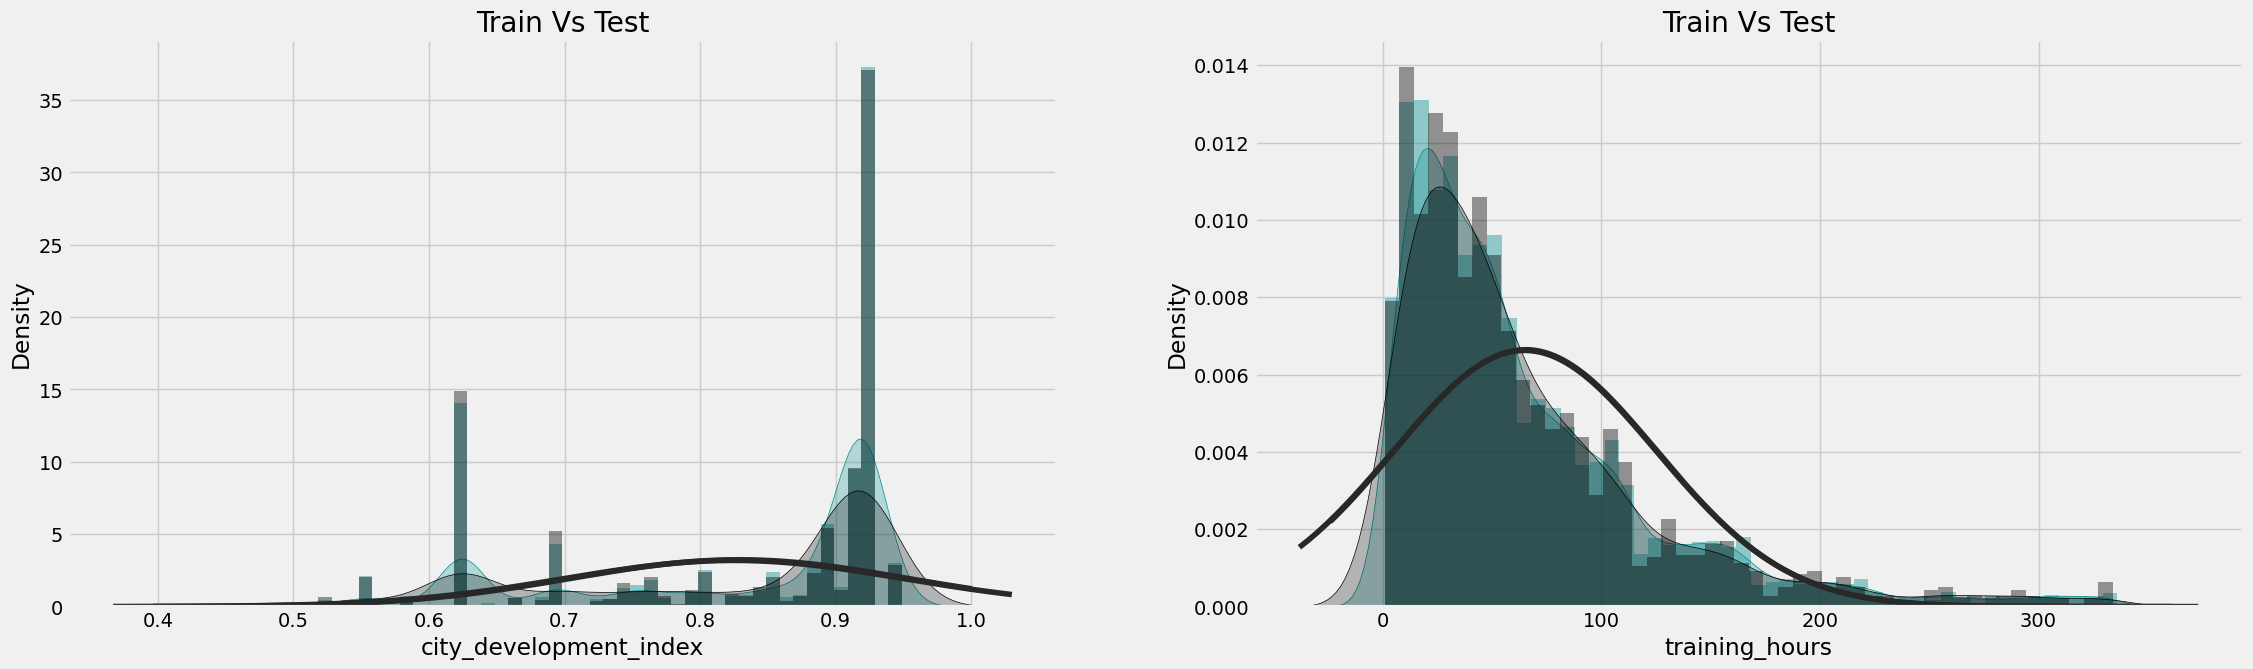

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(25, 7))
sns.distplot(train.city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkcyan', ax=axs[0])
sns.distplot(train.training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkcyan', ax=axs[1])
axs[0].set_title('Train Vs Test')
sns.distplot(test.city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='k', ax=axs[0])
sns.distplot(test.training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True},norm_hist=True,  color='k', ax=axs[1])
axs[1].set_title('Train Vs Test')

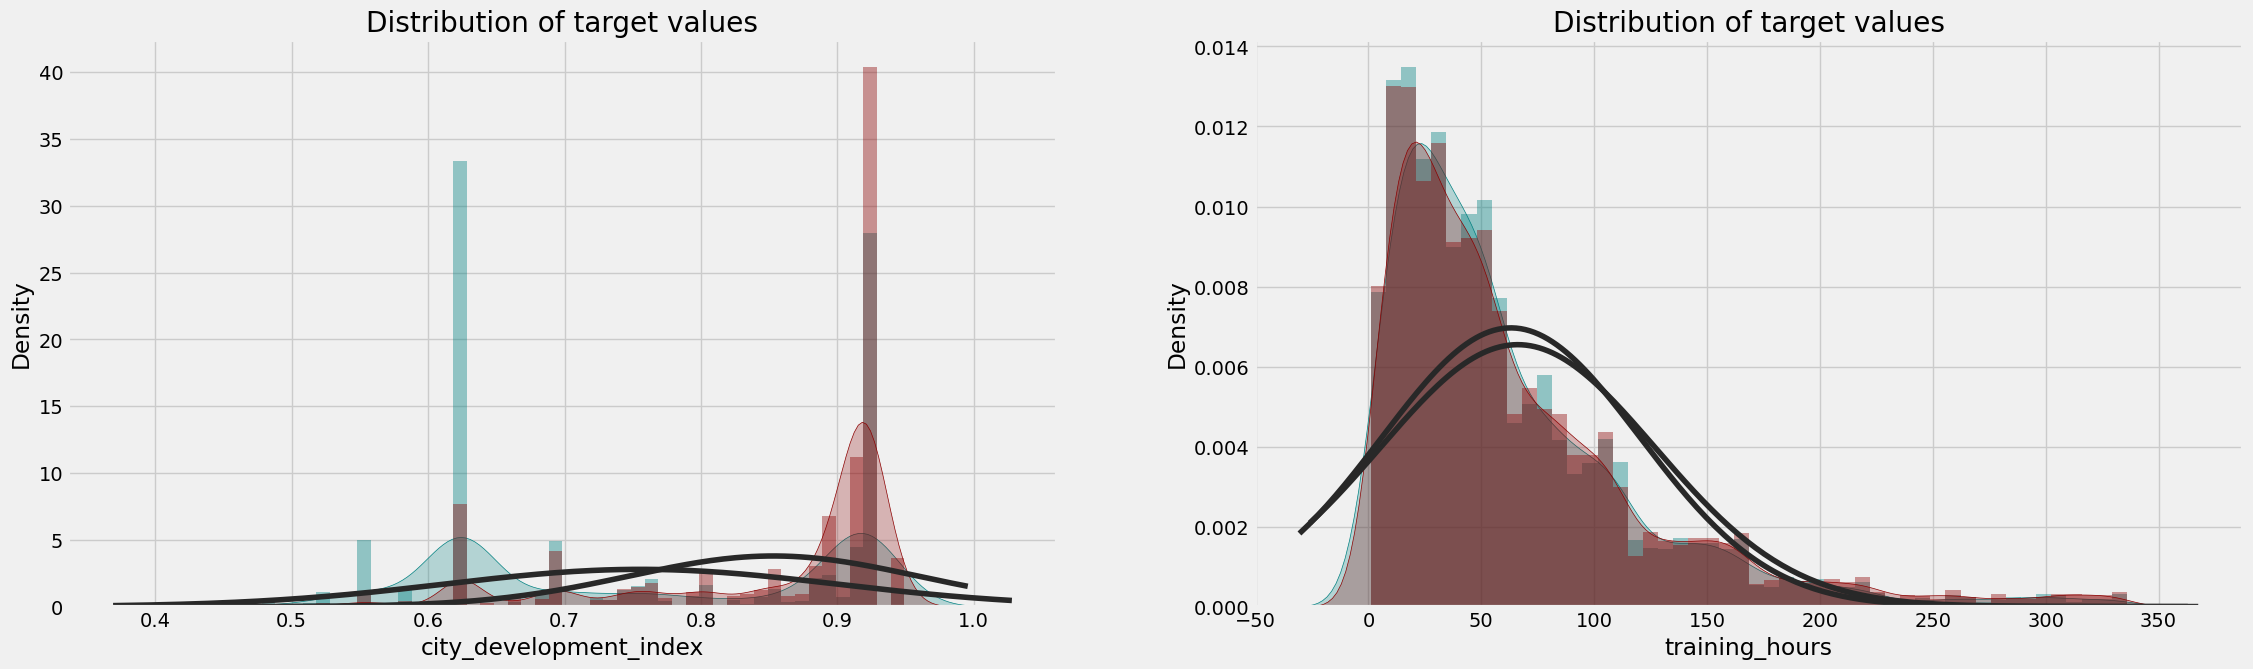

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(25, 7))
sns.distplot(train[train.target==1].city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='teal', ax=axs[0])
sns.distplot(train[train.target==0].city_development_index,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkred', ax=axs[0])
axs[0].set_title('Distribution of target values')

sns.distplot(train[train.target==1].training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='teal', ax=axs[1])
sns.distplot(train[train.target==0].training_hours,bins=50,  fit=norm,kde=True,kde_kws={"shade": True},norm_hist=True,  color='darkred', ax=axs[1])
axs[1].set_title('Distribution of target values')
plt.show()

In [18]:
del train["enrollee_id"]
del test["enrollee_id"]

# Categoricals

In [19]:
cats = nominals+ordinals


def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:
        #print("column:" , c ,"--Uniques:" , train[c].unique(), "--Cardinality:", train[c].unique().size)
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
        
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d

plt.style.use('fivethirtyeight')
catanadf = analyse_cats(train, cats)
catanadf

,"""feat""",uniques,cardinality,nans
0,city_nom,"[city_103, city_40, city_21, city_115, city_162, city_176, city_160, city_46, city_61, city_114, city_13, city_159, city_102, city_67, city_100, city_16, city_71, city_104, city_64, city_101, city_83, city_105, city_73, city_75, city_41, city_11, city_93, city_90, city_36, city_20, city_57, city...",123,0
1,gender_nom,"[Male, nan, Female, Other]",4,4508
2,relevent_experience_nom,"[Has relevent experience, No relevent experience]",2,0
3,enrolled_university_nom,"[no_enrollment, Full time course, nan, Part time course]",4,386
4,major_discipline_nom,"[STEM, Business Degree, nan, Arts, Humanities, No Major, Other]",7,2813
5,company_type_nom,"[nan, Pvt Ltd, Funded Startup, Early Stage Startup, Other, Public Sector, NGO]",7,6140
6,education_level_ord,"[Graduate, Masters, High School, nan, Phd, Primary School]",6,460
7,experience_ord,"[>20, 15, 5, <1, 11, 13, 7, 17, 2, 16, 1, 4, 10, 14, 18, 19, 12, 3, 6, 9, 8, 20, nan]",23,65
8,company_size_ord,"[nan, 50-99, <10, 10000+, 5000-9999, 1000-4999, 10/49, 100-500, 500-999]",9,5938
9,last_new_job_ord,"[1, >4, never, 4, 3, 2, nan]",7,423


# Missing Values

In [20]:
pd.DataFrame(train.isna().sum(axis = 0) / len(train), columns = ["missing percent"]).sort_values("missing percent", ascending = False)

,missing percent
company_type_nom,0.320493
company_size_ord,0.309949
gender_nom,0.235306
major_discipline_nom,0.146832
education_level_ord,0.024011
last_new_job_ord,0.022080
enrolled_university_nom,0.020148
experience_ord,0.003393
city_nom,0.000000
city_development_index,0.000000


In [21]:
def null_analysis(df):
  '''
  desc: get nulls for each column in counts & percentages
  arg: dataframe
  return: dataframe
  '''
  null_cnt = df.isnull().sum() # calculate null counts
  null_cnt = null_cnt[null_cnt!=0] # remove non-null cols
  null_percent = null_cnt / len(df) * 100 # calculate null percentages
  null_table = pd.concat([pd.DataFrame(null_cnt), pd.DataFrame(null_percent)], axis=1)
  null_table.columns = ['counts', 'percentage']
  null_table.sort_values('counts', ascending=False, inplace=True)
  return null_table

null_table = null_analysis(train)
#plt.bar(null_table.reset_index(), x='index', y='percentage', text='counts', height=500)
null_table

,counts,percentage
company_type_nom,6140,32.049274
company_size_ord,5938,30.994885
gender_nom,4508,23.530640
major_discipline_nom,2813,14.683161
education_level_ord,460,2.401086
last_new_job_ord,423,2.207955
enrolled_university_nom,386,2.014824
experience_ord,65,0.339284


In [22]:
null_table.reset_index()

,index,counts,percentage
0,company_type_nom,6140,32.049274
1,company_size_ord,5938,30.994885
2,gender_nom,4508,23.530640
3,major_discipline_nom,2813,14.683161
4,education_level_ord,460,2.401086
5,last_new_job_ord,423,2.207955
6,enrolled_university_nom,386,2.014824
7,experience_ord,65,0.339284


<AxesSubplot:xlabel='counts', ylabel='index'>

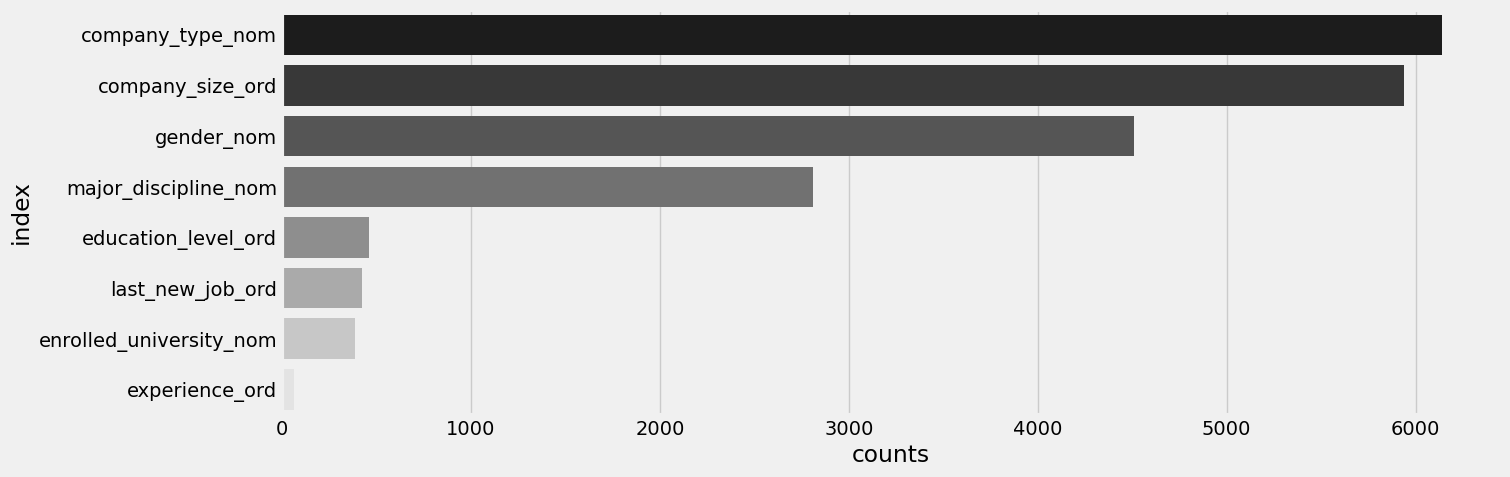

In [23]:
plt.figure(figsize=(14, 5))
sns.barplot(data= null_table.reset_index()[['index', 'counts']], x= 'counts', y='index', palette='gray')

# Data Preprocessing

In [24]:
train = tr_orig.copy()
test = ts_orig.copy()

del train["enrollee_id"]
del test["enrollee_id"]

## Ordinal Encoding

In [25]:
for c in ordinals:
    print(c, list(train[c].unique()))

education_level_ord ['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School']
experience_ord ['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]
company_size_ord [nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999']
last_new_job_ord ['1', '>4', 'never', '4', '3', '2', nan]


In [26]:
def OrdMapping(df):
    
    
    education_level_ord_mapping = {'Primary School': 0,'High School': 1,'Graduate': 2 , 'Masters':3,'Phd': 4 }
    experience_ord_mapping= {'<1':0, '1':2, '2':3, '3':4,'4':5, '5':6, '6':7, '7':8, '8':9,'9':10, '10':11, '12':13, '13':14,'14':15, '15':16, '16':17,  '17':18,'18':19, '19':20,'20':21,'>20':22}
    company_size_ord_mapping = {'<10':0 ,'10/49':1,'50-99':2, '100-500':3, '500-999':4, '1000-4999':5,'5000-9999':6, '10000+':7}
    
    last_new_job_ord_mapping = {'never':0,'1':1,'2':2,'3':3,'4':4,'>4':5}
    df['education_level_ord'] = df.education_level_ord.map(education_level_ord_mapping)
    df['experience_ord'] = df.experience_ord.map(experience_ord_mapping)
    df['company_size_ord'] = df.company_size_ord.map(company_size_ord_mapping)
    df['last_new_job_ord'] = df.last_new_job_ord.map(last_new_job_ord_mapping)
     
    return df

In [27]:
train = OrdMapping(train)
test = OrdMapping(test)

In [28]:
train.head()

,city_nom,city_development_index,gender_nom,relevent_experience_nom,enrolled_university_nom,education_level_ord,major_discipline_nom,experience_ord,company_size_ord,company_type_nom,last_new_job_ord,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,2.0,STEM,22.0,NaN,NaN,1.0,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,2.0,STEM,16.0,2.0,Pvt Ltd,5.0,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,2.0,STEM,6.0,NaN,NaN,0.0,83,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,2.0,Business Degree,0.0,NaN,Pvt Ltd,0.0,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,3.0,STEM,22.0,2.0,Funded Startup,4.0,8,0.0


In [29]:
test.head()

,city_nom,city_development_index,gender_nom,relevent_experience_nom,enrolled_university_nom,education_level_ord,major_discipline_nom,experience_ord,company_size_ord,company_type_nom,last_new_job_ord,training_hours
0,city_41,0.827,Male,Has relevent experience,Full time course,2.0,STEM,10.0,0.0,NaN,1.0,21
1,city_103,0.920,Female,Has relevent experience,no_enrollment,2.0,STEM,6.0,NaN,Pvt Ltd,1.0,98
2,city_21,0.624,Male,No relevent experience,no_enrollment,1.0,NaN,0.0,NaN,Pvt Ltd,0.0,15
3,city_13,0.827,Male,Has relevent experience,no_enrollment,3.0,STEM,NaN,1.0,Pvt Ltd,1.0,39
4,city_103,0.920,Male,Has relevent experience,no_enrollment,2.0,STEM,22.0,7.0,Pvt Ltd,5.0,72


## Nominal Encoding

In [30]:
for c in nominals:
    le = LabelEncoder()
    le.fit(list(train[c].astype(str)) + list(test[c].astype(str)))
    train[c] = le.transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('target mapping :  ',c ,  le_name_mapping)

target mapping :   city_nom {'city_1': 0, 'city_10': 1, 'city_100': 2, 'city_101': 3, 'city_102': 4, 'city_103': 5, 'city_104': 6, 'city_105': 7, 'city_106': 8, 'city_107': 9, 'city_109': 10, 'city_11': 11, 'city_111': 12, 'city_114': 13, 'city_115': 14, 'city_116': 15, 'city_117': 16, 'city_118': 17, 'city_12': 18, 'city_120': 19, 'city_121': 20, 'city_123': 21, 'city_126': 22, 'city_127': 23, 'city_128': 24, 'city_129': 25, 'city_13': 26, 'city_131': 27, 'city_133': 28, 'city_134': 29, 'city_136': 30, 'city_138': 31, 'city_139': 32, 'city_14': 33, 'city_140': 34, 'city_141': 35, 'city_142': 36, 'city_143': 37, 'city_144': 38, 'city_145': 39, 'city_146': 40, 'city_149': 41, 'city_150': 42, 'city_152': 43, 'city_155': 44, 'city_157': 45, 'city_158': 46, 'city_159': 47, 'city_16': 48, 'city_160': 49, 'city_162': 50, 'city_165': 51, 'city_166': 52, 'city_167': 53, 'city_171': 54, 'city_173': 55, 'city_175': 56, 'city_176': 57, 'city_179': 58, 'city_18': 59, 'city_180': 60, 'city_19': 61,

In [31]:
cats = ordinals + nominals

imp = SimpleImputer(strategy = "most_frequent")
train[cats] = imp.fit_transform(train[cats])
test[cats] = imp.fit_transform(test[cats])

In [32]:
train.isnull().sum()

city_nom                   0
city_development_index     0
gender_nom                 0
relevent_experience_nom    0
enrolled_university_nom    0
education_level_ord        0
major_discipline_nom       0
experience_ord             0
company_size_ord           0
company_type_nom           0
last_new_job_ord           0
training_hours             0
target                     0
dtype: int64

In [33]:
target = train.pop("target")
nums = [c for c in train.columns if c not in cats]

In [34]:
ss = StandardScaler()
train[nums] = ss.fit_transform(train[nums])
test[nums] = ss.fit_transform(test[nums])

# Machine Learning

In [35]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C=0.1, solver='newton-cg',max_iter=100, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y),'val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
    
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))

fold: 0   - Starting ...
train auc: 0.7518750700991399 val auc: 0.7465905172182334
fold: 1   - Starting ...
train auc: 0.7485694177374875 val auc: 0.7529268028712608
fold: 2   - Starting ...
train auc: 0.7499452997493498 val auc: 0.7493505019884571
--------------------------------------------------
 Model auc:   0.7496226073593171


In [36]:
score_auc = []

oof_qd = np.zeros(len(train))
pred_qd = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target[train_ind], target[val_ind]
    
    qd =   QuadraticDiscriminantAnalysis()
    qd.fit(trn_data, y_train)
    oof_qd[val_ind] = qd.predict(val_data)
    y = qd.predict(trn_data)
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_qd[val_ind]))
       
    score_auc.append(roc_auc_score(y_val, oof_qd[val_ind]))
                            
    pred_qd += qd.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))

fold: 0   - Starting ...
train auc: 0.6824049282306284
val auc: 0.674879685290472
fold: 1   - Starting ...
train auc: 0.6842803687528868
val auc: 0.6837723535128404
fold: 2   - Starting ...
train auc: 0.6784523199993595
val auc: 0.6823025002411252
fold: 3   - Starting ...
train auc: 0.6843027432615811
val auc: 0.6805549082859411
fold: 4   - Starting ...
train auc: 0.680065898588901
val auc: 0.6779210873158619
--------------------------------------------------
 Model auc:   0.6798861069292481


## OHE

In [38]:
train = tr_orig.copy()
test = ts_orig.copy()


target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

train.fillna('UnKnown', inplace=True)
test.fillna('UnKnown', inplace=True)



data = pd.concat([train, test], axis=0)
data = pd.get_dummies(data)
train = data.iloc[:len(train), ]
test = data.iloc[:len(test), ]

In [39]:
data

,city_development_index,training_hours,city_nom_city_1,city_nom_city_10,city_nom_city_100,city_nom_city_101,city_nom_city_102,city_nom_city_103,city_nom_city_104,city_nom_city_105,...,company_type_nom_Public Sector,company_type_nom_Pvt Ltd,company_type_nom_UnKnown,last_new_job_ord_1,last_new_job_ord_2,last_new_job_ord_3,last_new_job_ord_4,last_new_job_ord_>4,last_new_job_ord_UnKnown,last_new_job_ord_never
0,0.920,36,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
1,0.776,47,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0.624,83,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.789,52,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.767,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,15,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2125,0.897,30,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2126,0.887,18,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2127,0.804,84,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [40]:
missing = test.isnull().sum()
print(missing[missing>0])

train.head()

Series([], dtype: int64)


,city_development_index,training_hours,city_nom_city_1,city_nom_city_10,city_nom_city_100,city_nom_city_101,city_nom_city_102,city_nom_city_103,city_nom_city_104,city_nom_city_105,...,company_type_nom_Public Sector,company_type_nom_Pvt Ltd,company_type_nom_UnKnown,last_new_job_ord_1,last_new_job_ord_2,last_new_job_ord_3,last_new_job_ord_4,last_new_job_ord_>4,last_new_job_ord_UnKnown,last_new_job_ord_never
0,0.920,36,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
1,0.776,47,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0.624,83,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.789,52,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.767,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [41]:
print(train.shape, test.shape)

(19158, 194) (2129, 194)


## LinearSVC

In [42]:
score_auc = []

oof_svm = np.zeros(len(train))
pred_svm = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target[train_ind], target[val_ind]
    
    lsvm =   LinearSVC(C=.0001, random_state=2020)
    lsvm.fit(trn_data, y_train)
    oof_svm[val_ind] = lsvm.predict(val_data)
    y = lsvm.predict(trn_data)
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_svm[val_ind]))
    score_auc.append(roc_auc_score(y_val, oof_svm[val_ind]))
                           
    pred_svm += lsvm.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))

fold: 0   - Starting ...
train auc: 0.5172872962053183
val auc: 0.5130854976402606
fold: 1   - Starting ...
train auc: 0.515933845769411
val auc: 0.5151775478494656
fold: 2   - Starting ...
train auc: 0.5147075774248933
val auc: 0.5195629900983973
fold: 3   - Starting ...
train auc: 0.516802809781018
val auc: 0.5132728702604694
fold: 4   - Starting ...
train auc: 0.5150985818056035
val auc: 0.5148535633405907
--------------------------------------------------
 Model auc:   0.5151904938378367


## Frequency Encoding

In [44]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

In [45]:
daset = pd.concat([train, test], axis=0)


for c in (cats):
    daset[c+'_freq'] = daset[c].map(daset.groupby(c).size() / daset.shape[0])
    indexer = pd.factorize(daset[c], sort=True)[1]
    daset[c] = indexer.get_indexer(daset[c])

train= daset.iloc[:len(train) , ]
test= daset.iloc[len(train): , ]
cols=train.columns
train.shape, test.shape

((19158, 22), (2129, 22))

In [46]:
train.isnull().sum()

city_nom                           0
city_development_index             0
gender_nom                         0
relevent_experience_nom            0
enrolled_university_nom            0
education_level_ord                0
major_discipline_nom               0
experience_ord                     0
company_size_ord                   0
company_type_nom                   0
last_new_job_ord                   0
training_hours                     0
education_level_ord_freq         460
experience_ord_freq               65
company_size_ord_freq           5938
last_new_job_ord_freq            423
city_nom_freq                      0
gender_nom_freq                 4508
relevent_experience_nom_freq       0
enrolled_university_nom_freq     386
major_discipline_nom_freq       2813
company_type_nom_freq           6140
dtype: int64

In [47]:
imp = SimpleImputer(strategy='constant')
train = imp.fit_transform(train)
test  = imp.transform(test)

ss = StandardScaler()
train = ss.fit_transform(train)
test  = ss.transform(test)

## LogisticRegression

In [48]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train[train_ind], train[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C= 1,max_iter=200, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
    
                        
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print('-'*50)
print(' Model auc:  ', np.mean(score_auc))

fold: 0   - Starting ...
train auc: 0.7927518439349438
val auc: 0.7845561421768957
fold: 1   - Starting ...
train auc: 0.7908308592270505
val auc: 0.7879848895080325
fold: 2   - Starting ...
train auc: 0.7879599680297054
val auc: 0.7930706148598645
--------------------------------------------------
 Model auc:   0.788537215514931


# Hash Encoding

In [50]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
del train['enrollee_id']
del test['enrollee_id']

data = pd.concat([train, test], axis=0)

In [51]:
#Create object for hash encoder
encoder=ce.HashingEncoder(cols=cats,n_components=6)
data = encoder.fit_transform(data)
train = data.iloc[:len(train), ]
test = data.iloc[len(train):, ]

## LogisticRegression

In [52]:
score_auc = []

oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    lr = LogisticRegression(C= 0.1,max_iter=200, random_state=2020, class_weight={0: 1, 1:3})
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = lr.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('train auc:' , roc_auc_score(y_train, y))
    
    print('val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
      
    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
    
                        
    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits
    
print(' Model auc: -------> ', np.mean(score_auc))

fold: 0   - Starting ...
train auc: 0.7543929058740558
val auc: 0.7578584558823529
fold: 1   - Starting ...
train auc: 0.7593255763900766
val auc: 0.7383192856050436
fold: 2   - Starting ...
train auc: 0.7513594999848231
val auc: 0.7690154888564079
fold: 3   - Starting ...
train auc: 0.7560450855863974
val auc: 0.7503604615390318
fold: 4   - Starting ...
train auc: 0.7544863839311073
val auc: 0.7572854820146513
 Model auc: ------->  0.7545678347794975
